STEP 1: Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/Fracture_Project/MURA.zip'
extract_path = '/content/MURA'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("MURA dataset extracted.")

MURA dataset extracted.


STEP 2: Import Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

STEP 3: Load CSVs and Explore Labels

In [ ]:
BASE_PATH = '/content/MURA/MURA-v1.1'

# Load CSVs
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train_labeled_studies.csv'), header=None)
val_df = pd.read_csv(os.path.join(BASE_PATH, 'valid_labeled_studies.csv'), header=None)

train_df.columns = ['path', 'label']
val_df.columns = ['path', 'label']

# Convert to int
train_df['label'] = train_df['label'].astype(int)
val_df['label'] = val_df['label'].astype(int)

# Preview
train_df.head()




,path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1


In [ ]:
# Count total images in train set and validation set
train_image_count = sum([len(glob(os.path.join('/content/MURA/', path, '*.png'))) for path in train_df['path']])
val_image_count = sum([len(glob(os.path.join('/content/MURA', path, '*.png'))) for path in val_df['path']])

print("Total training images:", train_image_count)
print("Total validation images:", val_image_count)

Total training images: 36808
Total validation images: 3197


In [ ]:
from glob import glob
import os

def count_images_by_label(df, base_dir):
    normal_count = 0
    abnormal_count = 0

    for _, row in df.iterrows():
        label = row['label']
        path = os.path.join(base_dir, row['path'])
        num_images = len(glob(os.path.join(path, '*.png')))
        if label == 0:
            normal_count += num_images
        else:
            abnormal_count += num_images

    return normal_count, abnormal_count

# Paths
train_base = '/content/MURA/'
val_base = '/content/MURA'

# Counts
train_normal, train_abnormal = count_images_by_label(train_df, train_base)
val_normal, val_abnormal = count_images_by_label(val_df, val_base)

print(f"Train - Normal: {train_normal}, Abnormal: {train_abnormal}")
print(f"Validation - Normal: {val_normal}, Abnormal: {val_abnormal}")


Train - Normal: 21935, Abnormal: 14873
Validation - Normal: 1667, Abnormal: 1530


<ipython-input-34-485360231>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels_total, y=total_images, palette="Blues_r", ax=axes[0])
<ipython-input-34-485360231>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_labels, y=train_counts, palette="Greens_d", ax=axes[1])
<ipython-input-34-485360231>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=val_labels, y=val_counts, palette="Oranges", ax=axes[2])


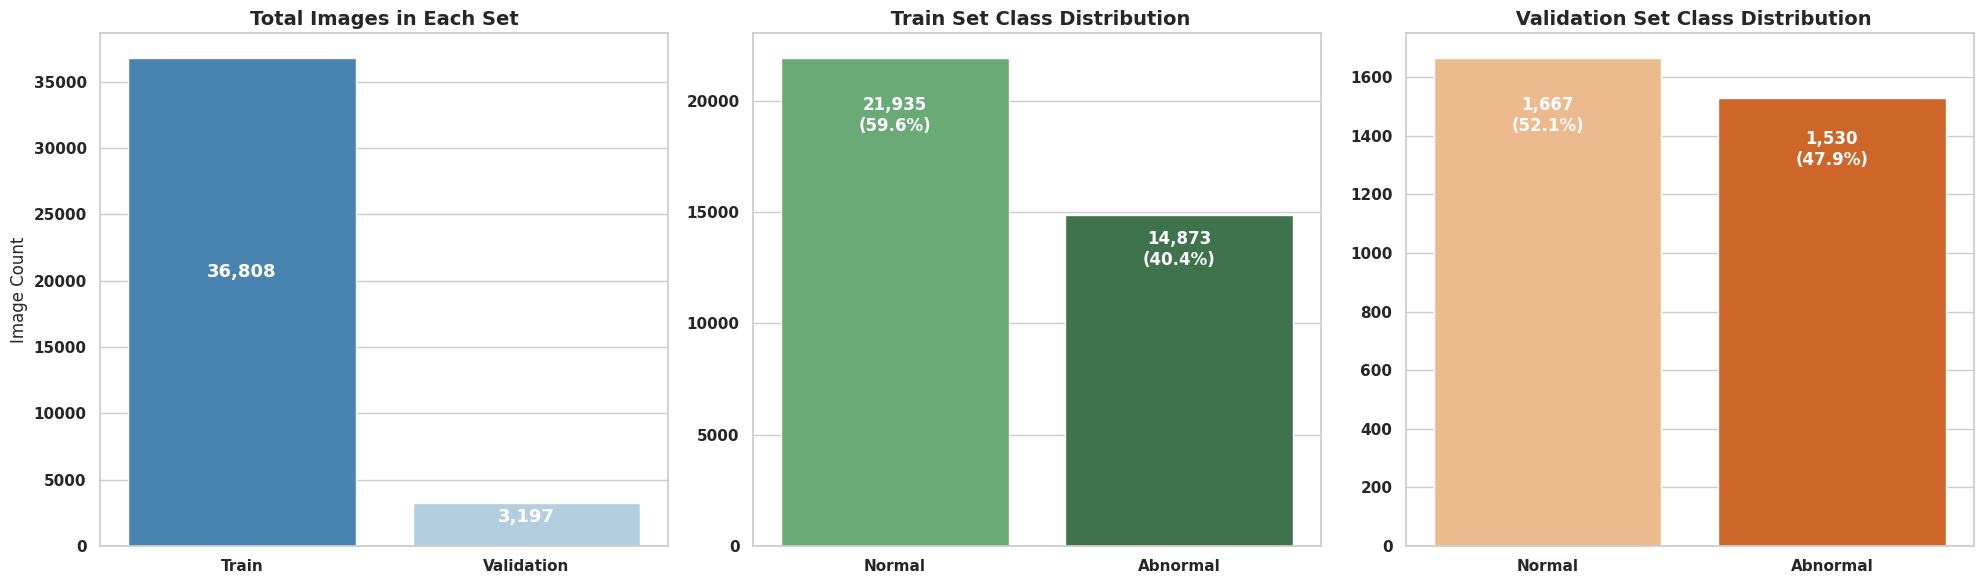

In [ ]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12, 'font.weight': 'bold'})

# Data
total_images = [train_image_count, val_image_count]
labels_total = ['Train', 'Validation']

train_counts = [21935, 14873]
train_labels = ['Normal', 'Abnormal']

val_counts = [1667, 1530]
val_labels = ['Normal', 'Abnormal']

# Plot
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# === 1. Total Image Count ===
sns.barplot(x=labels_total, y=total_images, palette="Blues_r", ax=axes[0])
axes[0].set_title('Total Images in Each Set', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Image Count')
for i, count in enumerate(total_images):
    axes[0].text(i, count * 0.55, f'{count:,}', ha='center', fontsize=13, color='white', weight='bold')

# === 2. Train Class Distribution ===
sns.barplot(x=train_labels, y=train_counts, palette="Greens_d", ax=axes[1])
axes[1].set_title(' Train Set Class Distribution', fontsize=14, fontweight='bold')
for i, count in enumerate(train_counts):
    pct = (count / sum(train_counts)) * 100
    axes[1].text(i, count * 0.85, f'{count:,}\n({pct:.1f}%)', ha='center', fontsize=12, color='white', weight='bold')

# === 3. Validation Class Distribution ===
sns.barplot(x=val_labels, y=val_counts, palette="Oranges", ax=axes[2])
axes[2].set_title(' Validation Set Class Distribution', fontsize=14, fontweight='bold')
for i, count in enumerate(val_counts):
    pct = (count / sum(val_counts)) * 100
    axes[2].text(i, count * 0.85, f'{count:,}\n({pct:.1f}%)', ha='center', fontsize=12, color='white', weight='bold')

plt.tight_layout()
plt.show()


 STEP 4: Exploratory Data Analysis (EDA)

<ipython-input-46-36864529>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=body_part_counts, y='Body Part', x='Image Count', palette='magma')


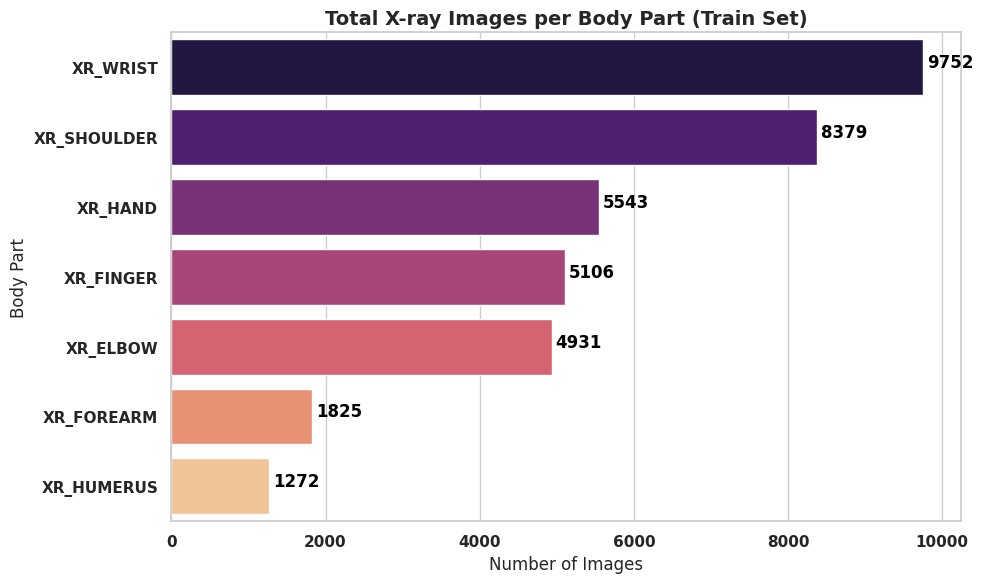

In [ ]:
# plt.figure(figsize=(10, 5))
# ax = sns.countplot(x='body_part', data=train_df, order=train_df['body_part'].value_counts().index, palette='cubehelix')

# # Add counts above bars
# for p in ax.patches:
#     count = int(p.get_height())
#     ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
#                 ha='center', va='bottom', fontsize=11, weight='bold')

# plt.title("Train Set - Image Count per Body Part", fontsize=14, weight='bold')
# plt.xlabel('Body Part')
# plt.ylabel('Study Count')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Use your .csv file that contains all image paths
df = pd.read_csv('/content/MURA/MURA-v1.1/train_image_paths.csv', header=None)
df.columns = ['path']

# Extract body part from path (e.g., XR_SHOULDER)
df['body_part'] = df['path'].apply(lambda x: x.split('/')[2])

# Count images per body part
body_part_counts = df['body_part'].value_counts().reset_index()
body_part_counts.columns = ['Body Part', 'Image Count']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=body_part_counts, y='Body Part', x='Image Count', palette='magma')
plt.title('Total X-ray Images per Body Part (Train Set)', fontsize=14, weight='bold')
plt.xlabel('Number of Images')
plt.ylabel('Body Part')

# Add count labels
for index, row in body_part_counts.iterrows():
    plt.text(row['Image Count'] + 50, index, str(row['Image Count']), color='black', weight='bold')

plt.tight_layout()
plt.show()


 Total number of images in train_image_paths.csv and  Total number of image files in all study folders listed in train_labeled_studies.csv

In [ ]:
df_paths = pd.read_csv('/content/MURA/MURA-v1.1/train_image_paths.csv', header=None)
print("Total image paths listed:", len(df_paths))

import os
from glob import glob

df_studies = pd.read_csv('/content/MURA/MURA-v1.1/train_labeled_studies.csv', header=None)
df_studies.columns = ['path', 'label']

image_count = 0
for study_path in df_studies['path']:
    full_path = os.path.join('/content/MURA', study_path)  # <-- FIXED THIS LINE
    images = glob(os.path.join(full_path, '*.png'))
    image_count += len(images)

print("Total image files from all labeled studies:", image_count)


Total image paths listed: 36808
Total image files from all labeled studies: 36808


Study path: MURA-v1.1/train/XR_HAND/patient10324/study1_negative/
Found images: ['/content/MURA/MURA-v1.1/train/XR_HAND/patient10324/study1_negative/image2.png', '/content/MURA/MURA-v1.1/train/XR_HAND/patient10324/study1_negative/image1.png']
Study path: MURA-v1.1/train/XR_FINGER/patient03009/study1_positive/
Found images: ['/content/MURA/MURA-v1.1/train/XR_FINGER/patient03009/study1_positive/image2.png', '/content/MURA/MURA-v1.1/train/XR_FINGER/patient03009/study1_positive/image3.png', '/content/MURA/MURA-v1.1/train/XR_FINGER/patient03009/study1_positive/image1.png']


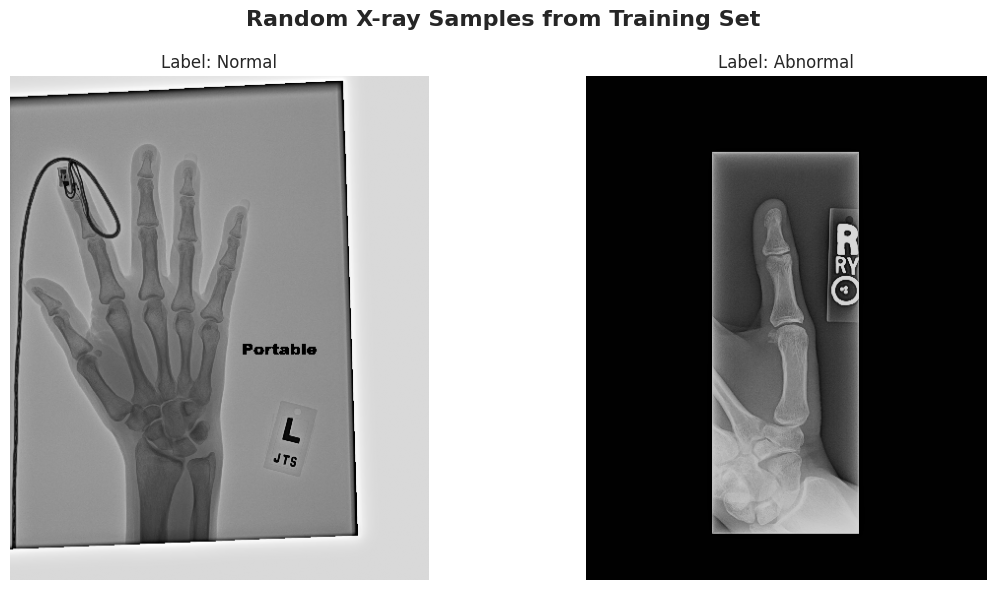

In [ ]:
import matplotlib.pyplot as plt
import random
from PIL import Image
from glob import glob
import os

# Corrected base directory
BASE_PATH = '/content/MURA'

# Separate normal and abnormal
normal_paths = train_df[train_df['label'] == 0]['path'].values
abnormal_paths = train_df[train_df['label'] == 1]['path'].values

# Function to collect images from a study path
def collect_images(study_path):
    full_path = os.path.join(BASE_PATH, study_path)
    return glob(os.path.join(full_path, '*.png'))

# Plot
plt.figure(figsize=(12, 6))

for i, label_paths in enumerate([normal_paths, abnormal_paths]):
    study_path = random.choice(label_paths)
    image_paths = collect_images(study_path)
    print(f"Study path: {study_path}")
    print(f"Found images: {image_paths}")
    if not image_paths:
        continue
    try:
        img = Image.open(image_paths[0])
    except Exception as e:
        print("Error loading image:", e)
        continue

    plt.subplot(1, 2, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title("Label: Normal" if i == 0 else "Label: Abnormal")
    plt.axis('off')

plt.suptitle("Random X-ray Samples from Training Set", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()


In [ ]:
print("Sample study path:", study_path)
print("Image paths found:", image_paths)


Sample study path: MURA-v1.1/train/XR_WRIST/patient07262/study1_positive/
Image paths found: []


 STEP 5: Convert Paths to Full Image Files

In [ ]:
import glob
image_paths, labels = [], []
for _, row in train_df.iterrows():
    folder = os.path.join('/content/MURA', row['path'])
    for img_file in glob.glob(folder + '/*.png'):
        image_paths.append(img_file)
        labels.append(row['label'])

val_image_paths, val_labels = [], []
for _, row in val_df.iterrows():
    folder = os.path.join('/content/MURA', row['path'])
    for img_file in glob.glob(folder + '/*.png'):
        val_image_paths.append(img_file)
        val_labels.append(row['label'])

print("✅ Total training images:", len(image_paths))
print("✅ Total validation images:", len(val_image_paths))


✅ Total training images: 36808
✅ Total validation images: 3197


In [ ]:
# ✅ STEP 5: Class Weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)


Class Weights: {0: np.float64(0.8390243902439024), 1: np.float64(1.2374100719424461)}


In [ ]:
#extra02 data agumentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)


STEP 6: Prepare TensorFlow Datasets

In [ ]:
paths_tensor = tf.constant(image_paths)
labels_tensor = tf.constant(labels)

val_paths_tensor = tf.constant(val_image_paths)
val_labels_tensor = tf.constant(val_labels)

def load_rgb_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, (224, 224))
    img = tf.image.grayscale_to_rgb(img)
    img = tf.cast(img, tf.float32)
    return img, label

from tensorflow.keras.applications.resnet50 import preprocess_input

def preprocess(img, label):
    return preprocess_input(img), label

# Apply map functions
train_dataset_rgb = tf.data.Dataset.from_tensor_slices((paths_tensor, labels_tensor))
train_dataset_rgb = train_dataset_rgb.map(load_rgb_image).map(preprocess).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset_rgb = tf.data.Dataset.from_tensor_slices((val_paths_tensor, val_labels_tensor))
val_dataset_rgb = val_dataset_rgb.map(load_rgb_image).map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

# # ✅ STEP 6: Tensor Preparation
# paths_tensor = tf.constant(image_paths)
# labels_tensor = tf.constant(labels)
# val_paths_tensor = tf.constant(val_image_paths)
# val_labels_tensor = tf.constant(val_labels)

# def load_rgb_image(path, label):
#     img = tf.io.read_file(path)
#     img = tf.image.decode_png(img, channels=1)
#     img = tf.image.resize(img, (224, 224))
#     img = tf.image.grayscale_to_rgb(img)
#     img = tf.cast(img, tf.float32)
#     return img, label

# def preprocess(img, label):
#     return preprocess_input(img), label

# train_dataset_rgb = tf.data.Dataset.from_tensor_slices((paths_tensor, labels_tensor))
# train_dataset_rgb = train_dataset_rgb.map(load_rgb_image).map(preprocess).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

# val_dataset_rgb = tf.data.Dataset.from_tensor_slices((val_paths_tensor, val_labels_tensor))
# val_dataset_rgb = val_dataset_rgb.map(load_rgb_image).map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# ✅ STEP 7: Create ResNet50 Model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# ✅ STEP 8: Train Model with Class Weights
history = model.fit(train_dataset_rgb, validation_data=val_dataset_rgb, epochs=15, class_weight=class_weights_dict)

Epoch 1/15
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 243s 195ms/step - accuracy: 0.8675 - loss: 0.3315 - val_accuracy: 0.5227 - val_loss: 1.7075
Epoch 2/15
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 203s 172ms/step - accuracy: 0.8294 - loss: 0.4337 - val_accuracy: 0.5239 - val_loss: 1.6624
Epoch 3/15
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 200s 169ms/step - accuracy: 0.8224 - loss: 0.4509 - val_accuracy: 0.5267 - val_loss: 1.5407
Epoch 4/15
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 200s 170ms/step - accuracy: 0.8400 - loss: 0.4205 - val_accuracy: 0.5280 - val_loss: 1.6834
Epoch 5/15
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 187s 159ms/step - accuracy: 0.8356 - loss: 0.4426 - val_accuracy: 0.5346 - val_loss: 1.5159
Epoch 6/15
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 190s 160ms/step - accuracy: 0.8366 - loss: 0.4239 - val_accuracy: 0.5296 - val_loss: 1.6070
Epoch 7/15
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 202s 161ms/step - accuracy: 0.8337 - loss: 0.4322 - val_accuracy: 0.5314 - val_loss: 1.6449
Epoch 8/15
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 214s 171ms/step - ac

STEP 6: Create ResNet50 Model

In [ ]:
# ✅ STEP 9: Fine-tune Top Layers
for layer in base_model.layers[-50:]:
    layer.trainable = True
model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
history_finetune = model.fit(train_dataset_rgb, validation_data=val_dataset_rgb, epochs=5, class_weight=class_weights_dict)

Epoch 1/5
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 242s 183ms/step - accuracy: 0.7434 - loss: 0.5875 - val_accuracy: 0.5540 - val_loss: 1.2740
Epoch 2/5
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 199s 170ms/step - accuracy: 0.7770 - loss: 0.5024 - val_accuracy: 0.5809 - val_loss: 1.3342
Epoch 3/5
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 209s 176ms/step - accuracy: 0.8344 - loss: 0.3901 - val_accuracy: 0.6062 - val_loss: 1.3319
Epoch 4/5
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 252s 168ms/step - accuracy: 0.8773 - loss: 0.2970 - val_accuracy: 0.6128 - val_loss: 1.5485
Epoch 5/5
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 209s 174ms/step - accuracy: 0.9105 - loss: 0.2288 - val_accuracy: 0.6278 - val_loss: 1.7324


STEP 7: Train

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

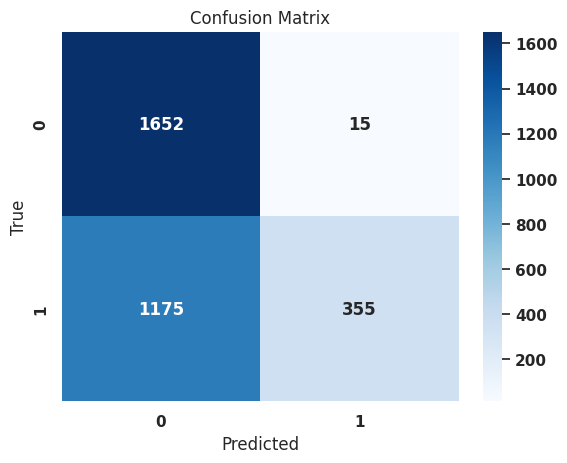

In [ ]:
# ✅ STEP 10: Evaluation
from sklearn.metrics import classification_report, confusion_matrix
y_true = []
y_pred = []
y_score = []
for img, label in val_dataset_rgb:
    preds = model.predict(img)
    y_true.extend(label.numpy())
    y_pred.extend((preds > 0.5).astype(int))
    y_score.extend(preds.flatten())

print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_resnet50.png')
plt.show()

 STEP 8: Grad-CAM for Model Explainability

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


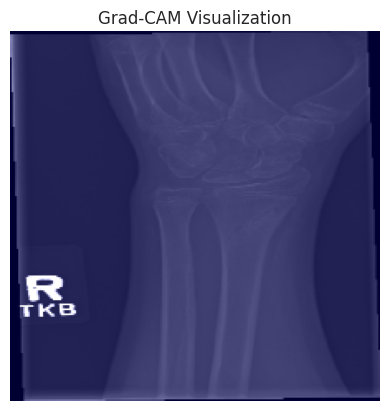

In [ ]:
import cv2
import matplotlib.cm as cm

def get_img_array(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, (224, 224))
    img = tf.image.grayscale_to_rgb(img)
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)
    return tf.expand_dims(img, axis=0)

# Grad-CAM Function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Visualize one sample image from validation set
sample_path = val_image_paths[0]
sample_array = get_img_array(sample_path)
heatmap = make_gradcam_heatmap(sample_array, model, 'conv5_block3_out')  # last conv layer of ResNet50

# Display Grad-CAM
img = cv2.imread(sample_path)
img = cv2.resize(img, (224, 224))
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap_colored = cm.jet(heatmap_resized)[..., :3]
superimposed_img = heatmap_colored * 0.4 + img / 255.0

plt.imshow(superimposed_img)
plt.axis('off')
plt.title('Grad-CAM Visualization')
plt.savefig('gradcam_resnet50.png')


plt.show()

STEP 9: Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

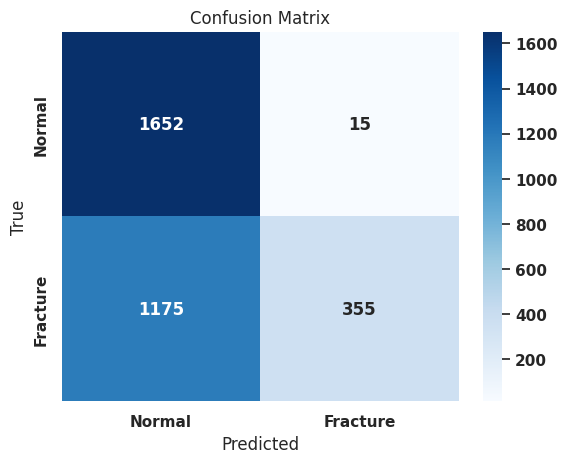

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
y_true = []
y_pred = []

for img, label in val_dataset_rgb:
    preds = model.predict(img)
    y_true.extend(label.numpy())
    y_pred.extend((preds > 0.5).astype(int))

# Print classification report
print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal (0)', 'Fracture (1)']))

# Count predictions
unique, counts = np.unique(y_pred, return_counts=True)
prediction_summary = dict(zip(['Normal (0)', 'Fracture (1)'], counts))
print("\n📊 Model Predictions Summary:")
for cls, count in prediction_summary.items():
    print(f"{cls}: {count} images")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fracture'], yticklabels=['Normal', 'Fracture'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_resnet50.png')
plt.show()


In [ ]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt

# # Get true labels and predicted probabilities
# y_true = []
# y_scores = []

# for images, labels in val_dataset_rgb:
#     preds = model.predict(images)
#     y_true.extend(labels.numpy())
#     y_scores.extend(preds.ravel())  # flatten the prediction probabilities

# # Compute ROC curve and AUC
# fpr, tpr, thresholds = roc_curve(y_true, y_scores)
# roc_auc = auc(fpr, tpr)

# # Plot ROC curve
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.show()
# ✅ STEP 11: ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='orange', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.savefig('roc_curve_resnet50.png')
plt.show()


NameError: name 'roc_curve' is not defined

#Show Predictions with Actual vs Predicted Labels

In [ ]:
import random
import matplotlib.pyplot as plt

# Create a list of (image_path, true_label) pairs from validation set
val_data_list = list(zip(val_image_paths, val_labels))

# Choose a few random samples
sample_images = random.sample(val_data_list, 6)

plt.figure(figsize=(15, 10))

for i, (img_path, true_label) in enumerate(sample_images):
    # Load and preprocess the image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, (224, 224))
    img_rgb = tf.image.grayscale_to_rgb(img)
    img_input = preprocess_input(tf.expand_dims(img_rgb, axis=0))

    # Predict
    pred = model.predict(img_input)
    pred_label = int(pred[0][0] > 0.5)

    # Plot
    plt.subplot(2, 3, i+1)
    plt.imshow(tf.squeeze(img_rgb), cmap='gray')
    plt.axis('off')
    plt.title(f"Actual: {'Fracture' if true_label else 'Normal'}\nPredicted: {'Fracture' if pred_label else 'Normal'}",
              color='green' if pred_label == true_label else 'red')

plt.suptitle('Model Predictions on Validation Images', fontsize=16)
plt.tight_layout()
plt.show()


NameError: name 'val_image_paths' is not defined